In [18]:
# Подключение PySpark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType

# Настройка Spark
conf = SparkConf().setAppName("Bike_Analysis").setMaster("local[*]")

# Подключение существующего SparkContext и создание SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [19]:
# Загрузка данных
trips_df = spark.read.csv("/content/drive/MyDrive/trips.csv", header=True, inferSchema=True)
stations_df = spark.read.csv("/content/drive/MyDrive/stations.csv", header=True, inferSchema=True)

# 1. Найти велосипед с максимальным временем пробега

In [20]:
# Группировка велосипедов по id, где каждому id соответствует его общее время пробега
# Сортировка результатов по значению общего времени пробега (самый максимальный сверху)
# Возвращение первого элемента в отсортированном списке
bike_max_duration = (
    trips_df.groupBy("bike_id")
    .agg(F.sum("duration").alias("total_duration"))
    .orderBy(F.desc("total_duration"))
    .first()
)
print(f"Велосипед с максимальным временем пробега: {bike_max_duration['bike_id']}\nВремя пробега: {bike_max_duration['total_duration']} сек")

Велосипед с максимальным временем пробега: 535
Время пробега: 18611693 сек


# 2. Найти наибольшее геодезическое расстояние между станциями

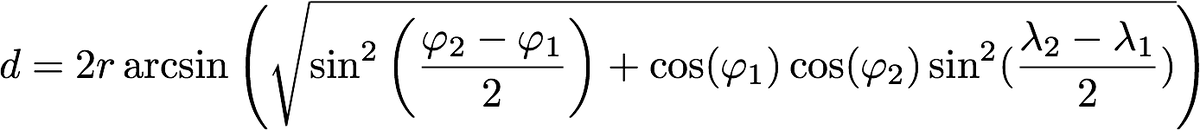

In [21]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371 # Радиус Земли (км)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2]) # Преобразование градусов в радианы

    # Вычисление разности широт и долгот
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Вычисление наибольшего расстояния по формуле хаверсина
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Извлечение необходимых столбцов из stations_df, формирование списка
stations_list = stations_df.select("id", "name", "lat", "long").collect()
max_distance = 0
station_a, station_b = None, None

for i in range(len(stations_list)):
    for j in range(i + 1, len(stations_list)):
        dist = haversine(
            stations_list[i]["lat"], stations_list[i]["long"],
            stations_list[j]["lat"], stations_list[j]["long"]
        )
        if dist > max_distance:
            max_distance = dist
            station_a = stations_list[i]["name"]
            station_b = stations_list[j]["name"]

print(f"Наибольшее расстояние: {max_distance:.2f} км между станциями {station_a} и {station_b}")

Наибольшее расстояние: 69.92 км между станциями SJSU - San Salvador at 9th и Embarcadero at Sansome


# 3. Найти путь велосипеда с максимальным временем пробега

In [22]:
# Фильтрование значений - только для определенного bike_id
# Выборка уникальных значений начальной и конечной станций (чтобы не было одинаковых путей)
bike_path_df = (
    trips_df.filter(F.col("bike_id") == bike_max_duration["bike_id"])
    .select("start_station_name", "end_station_name")
    .distinct()
)
print(f'Путь велосипеда {bike_max_duration["bike_id"]} через станции:')
bike_path_df.show(truncate=False)

Путь велосипеда 535 через станции:
+----------------------------------------+----------------------------------------+
|start_station_name                      |end_station_name                        |
+----------------------------------------+----------------------------------------+
|Golden Gate at Polk                     |Steuart at Market                       |
|2nd at Folsom                           |San Francisco Caltrain (Townsend at 4th)|
|Market at 10th                          |Market at 10th                          |
|Grant Avenue at Columbus Avenue         |Powell at Post (Union Square)           |
|San Francisco Caltrain (Townsend at 4th)|Steuart at Market                       |
|Embarcadero at Bryant                   |Davis at Jackson                        |
|Powell Street BART                      |Civic Center BART (7th at Market)       |
|Harry Bridges Plaza (Ferry Building)    |Grant Avenue at Columbus Avenue         |
|Washington at Kearney                   

# 4. Найти количество велосипедов в системе

In [23]:
# Рассчет количества только уникальных bike_id
num_bikes = trips_df.select("bike_id").distinct().count()
print(f"Общее количество велосипедов: {num_bikes}")

Общее количество велосипедов: 700


# 5. Найти пользователей, потративших более 3 часов на поездки

In [24]:
# Группировка данных по почтовым индексам (zip_code)
# Подсчет общей продолжительности поездок для каждого почтового индекса
# Фильтрация групп, где общая продолжительность поездок превышает 3 часа (10800 секунд)
# Выбор только столбца с почтовыми индексами
users_over_3_hours = (
    trips_df.groupBy("zip_code")
    .agg(F.sum("duration").alias("total_duration"))
    .filter(F.col("total_duration") > 10800)
    .select("zip_code")
)
print("Пользователи, потратившие более 3 часов:")
users_over_3_hours.show()

Пользователи, потратившие более 3 часов:
+--------+
|zip_code|
+--------+
|   94102|
|   95134|
|   84606|
|   80305|
|   60070|
|   95519|
|   43085|
|   91910|
|   77339|
|   48063|
|   85022|
|    1090|
|    2136|
|   11722|
|   95138|
|   94610|
|   94404|
|   80301|
|   91326|
|   90742|
+--------+
only showing top 20 rows

